# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [3]:
connect=sqlite3.connect('final.sqlite')


In [4]:
cleaned_data= pd.read_sql_query("select * from cleaned", connect)

In [5]:
cleaned_data.shape

(348260, 12)

In [6]:
cleaned_data['Time'] = pd.to_datetime(cleaned_data['Time'], unit = 's')
cleaned_data= cleaned_data.sort_values(by='Time')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [8]:
X_3k = cleaned_data['processed_review']
Y_3k = cleaned_data['Score']

In [25]:
X_train= X_3k[0:50000]


### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [26]:
#We will make the model learn the vocab from train dataset. We will use countvectorizer to serve our purpose
vec= CountVectorizer(min_df = 10)
bow_train = vec.fit_transform(X_train)




#normalize the data 
from sklearn import preprocessing
bow_train = preprocessing.normalize(bow_train)





In [27]:
print("After Vectorization")
print(bow_train.shape,Y_train.shape)



After Vectorization
(50000, 8706) (35000,)


In [28]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [29]:
type(bow_train)

scipy.sparse.csr.csr_matrix

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

k= [2,3,4,5,6,7,8,10]
inertia = []
for i in k:
    k_means = KMeans(n_clusters =i, random_state= 0).fit(bow_train)
    inertia.append(k_means.inertia_)

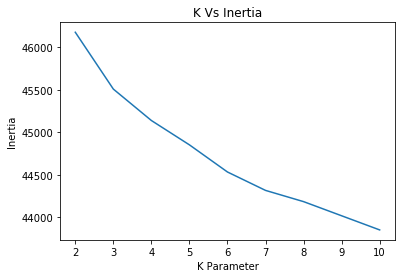

In [34]:
plt.plot(k,inertia)
plt.xlabel('K Parameter')
plt.ylabel('Inertia')
plt.title('K Vs Inertia')
plt.show()

In [35]:
#using the optimum k we will cluster the train data
opt_k = 6
k_means = KMeans(n_clusters =opt_k, random_state= 0).fit(bow_train)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [3]:
# Please write all the code with proper documentation

In [58]:
clust= [ [] for i in range(opt_k)]
for i in range(k_means.labels_.shape[0]):
    clust[k_means.labels_[i]].append(X_train.values[i])

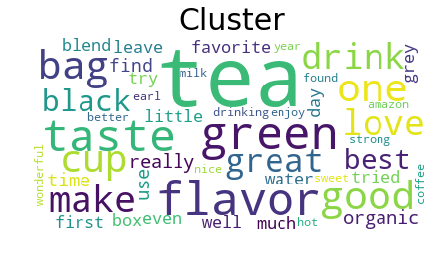

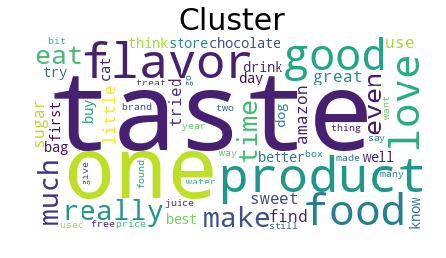

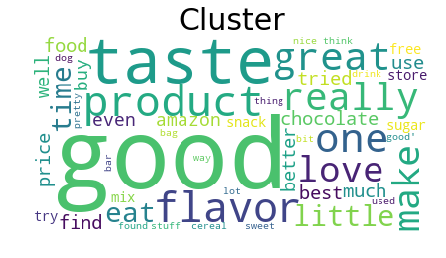

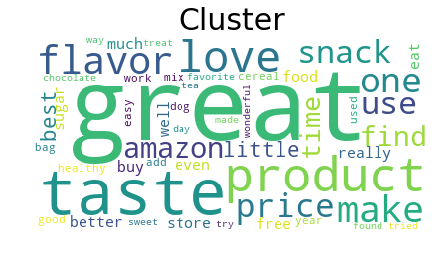

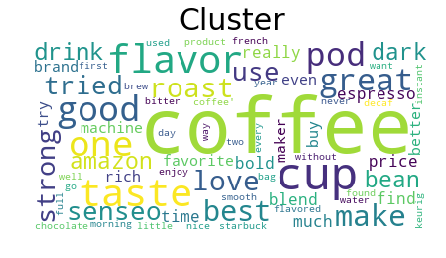

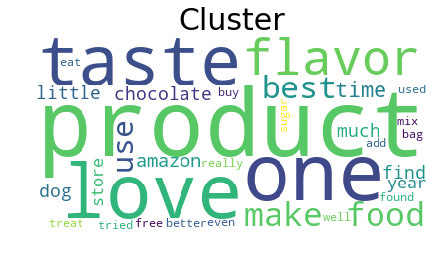

In [61]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster",size= 30,)
    plt.show() 
for cl in clust:
    cloud(cl)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

In [62]:
tfidf= TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)


#normalize the data 
from sklearn import preprocessing
tfidf_train = preprocessing.normalize(tfidf_train)


In [64]:
print("After Vectorization")
print(tfidf_train.shape)



After Vectorization
(50000, 42139)


In [65]:
k= [2,3,4,5,6,7,8,10]
inertia1 = []
for i in k:
    k_means = KMeans(n_clusters =i, random_state= 0).fit(tfidf_train)
    inertia1.append(k_means.inertia_)

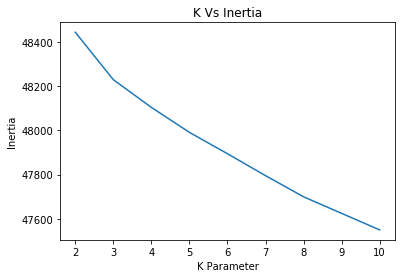

In [66]:
plt.plot(k,inertia1)
plt.xlabel('K Parameter')
plt.ylabel('Inertia')
plt.title('K Vs Inertia')
plt.show()

In [68]:
#using the optimum k we will cluster the train data
opt_k = 7
k_means = KMeans(n_clusters =opt_k, random_state= 0).fit(tfidf_train)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

In [69]:
clust1= [ [] for i in range(opt_k)]
for i in range(k_means.labels_.shape[0]):
    clust1[k_means.labels_[i]].append(X_train.values[i])

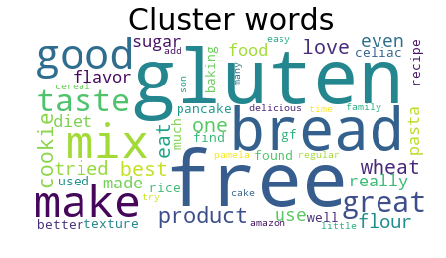

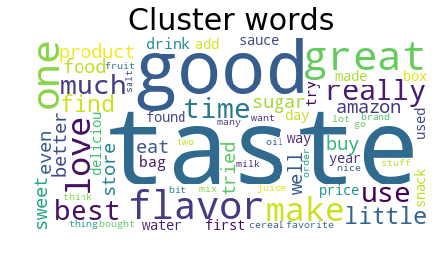

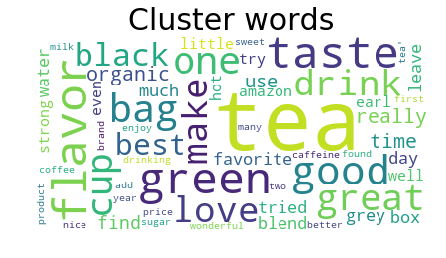

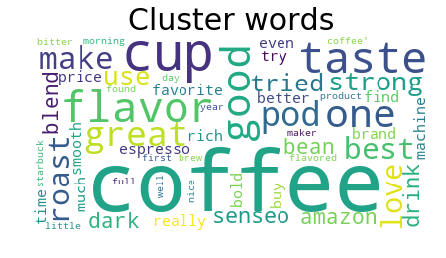

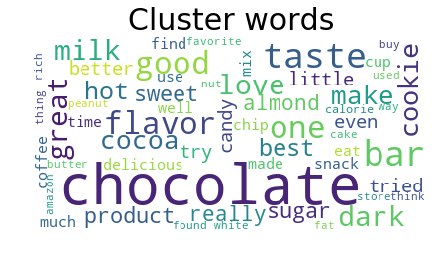

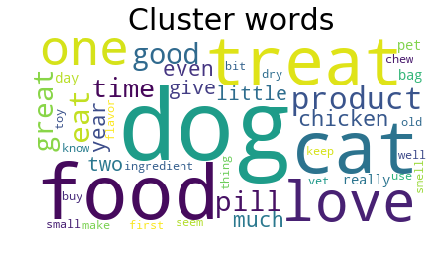

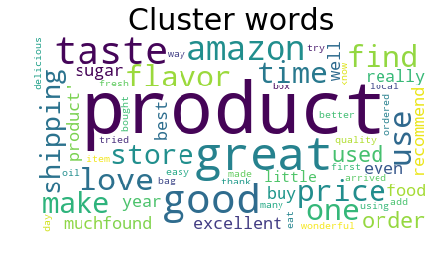

In [71]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust1:
    cloud(cl)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [72]:
# Train your own Word2Vec model using your own text corpus
i=0
sentance_train=[]
for sentance in X_train:
    sentance_train.append(sentance.split())

In [73]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13638
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


In [74]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_train.append(sent_vec)
print(len(vectors_train))
print(len(vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:21<00:00, 610.52it/s]


50000
50


In [75]:
k= [2,3,4,5,6,7,8,10]
inertia2 = []
for i in k:
    k_means = KMeans(n_clusters =i, random_state= 0).fit(vectors_train)
    inertia2.append(k_means.inertia_)

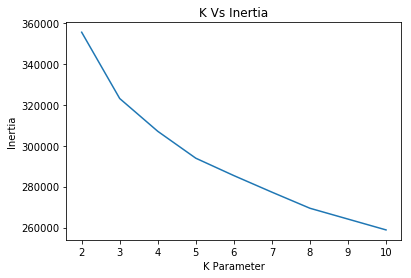

In [77]:
plt.plot(k,inertia2)
plt.xlabel('K Parameter')
plt.ylabel('Inertia')
plt.title('K Vs Inertia')
plt.show()

In [78]:
#using the optimum k we will cluster the train data
opt_k = 5
k_means = KMeans(n_clusters =opt_k, random_state= 0).fit(vectors_train)

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [79]:
clust2= [ [] for i in range(opt_k)]
for i in range(k_means.labels_.shape[0]):
    clust2[k_means.labels_[i]].append(X_train.values[i])

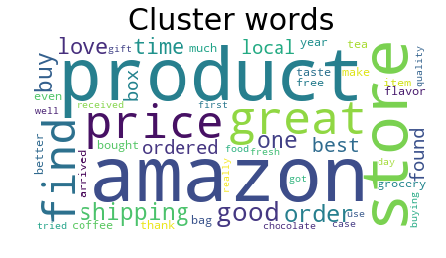

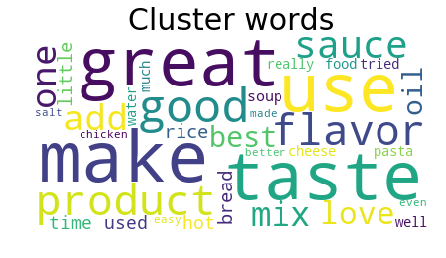

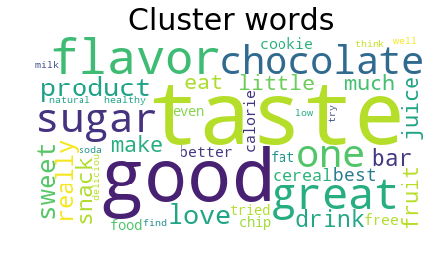

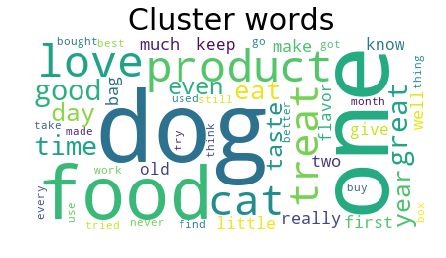

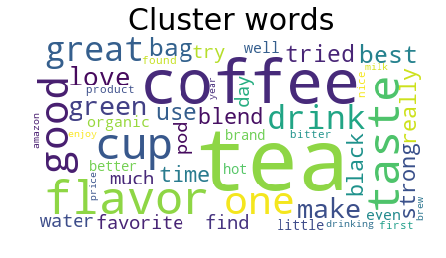

In [80]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust2:
    cloud(cl)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

In [81]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [13:15<00:00, 62.84it/s]


In [83]:
k= [2,3,4,5,6,7,8,10]
inertia3 = []
for i in k:
    k_means = KMeans(n_clusters =i, random_state= 0).fit(tfidf_sent_vectors)
    inertia3.append(k_means.inertia_)

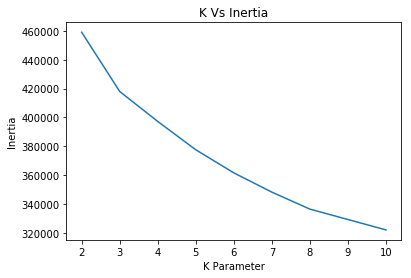

In [84]:
plt.plot(k,inertia3)
plt.xlabel('K Parameter')
plt.ylabel('Inertia')
plt.title('K Vs Inertia')
plt.show()

In [85]:
#using the optimum k we will cluster the train data
opt_k = 5
k_means = KMeans(n_clusters =opt_k, random_state= 0).fit(tfidf_sent_vectors)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

In [86]:
clust3= [ [] for i in range(opt_k)]
for i in range(k_means.labels_.shape[0]):
    clust3[k_means.labels_[i]].append(X_train.values[i])

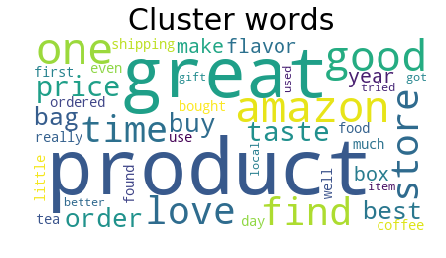

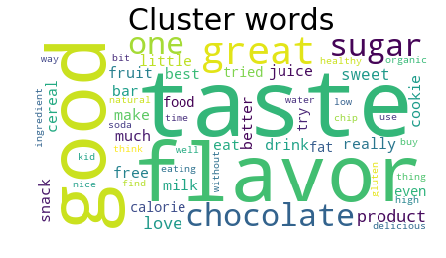

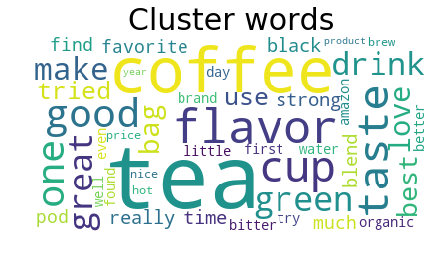

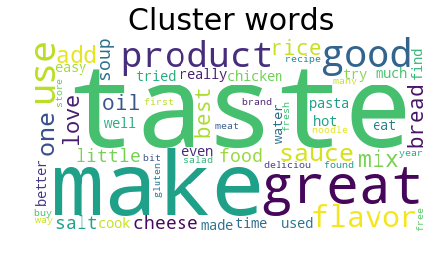

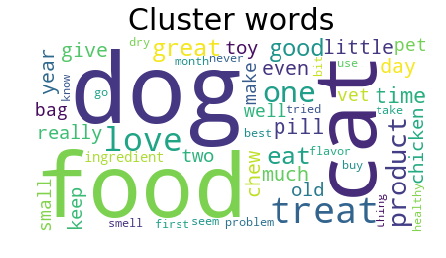

In [87]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust3:
    cloud(cl)

## [5.2] Agglomerative Clustering

In [88]:
X_data = cleaned_data['processed_review']

In [89]:
X_train = X_data[0:5000]

In [90]:
# Train your own Word2Vec model using your own text corpus
i=0
sentance_train=[]
for sentance in X_train:
    sentance_train.append(sentance.split())

In [91]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5000
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition']


In [92]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_train.append(sent_vec)
print(len(vectors_train))
print(len(vectors_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 751.97it/s]


5000
50


### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [93]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg = AgglomerativeClustering(n_clusters=2).fit(vectors_train)

In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg1 = AgglomerativeClustering(n_clusters=3).fit(vectors_train)

In [100]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg2 = AgglomerativeClustering(n_clusters=4).fit(vectors_train)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [96]:
clust = [ [] for i in range(2) ]
for i in range(agg.labels_.shape[0]):
    clust[agg.labels_[i]].append(X_train.values[i])

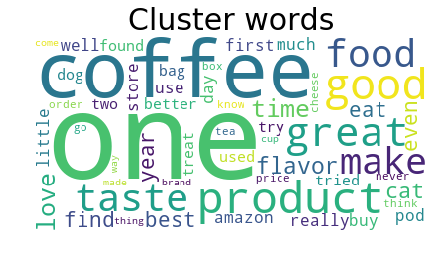

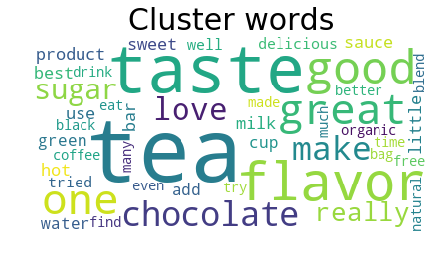

In [97]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust:
    cloud(cl)

In [104]:
clust1 = [ [] for i in range(3) ]
for i in range(agg1.labels_.shape[0]):
    clust1[agg1.labels_[i]].append(X_train.values[i])

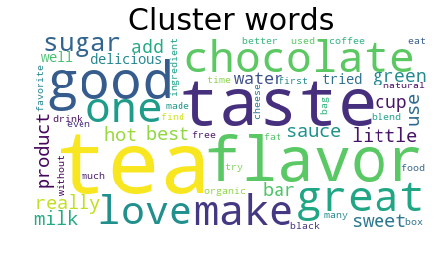

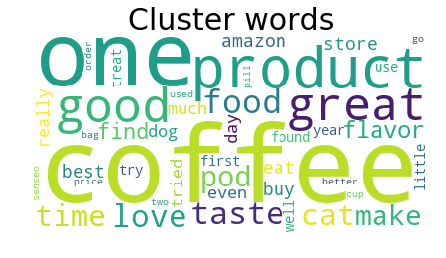

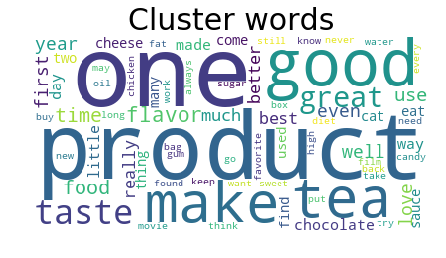

In [105]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust1:
    cloud(cl)

In [106]:
clust2 = [ [] for i in range(4) ]
for i in range(agg2.labels_.shape[0]):
    clust2[agg2.labels_[i]].append(X_train.values[i])

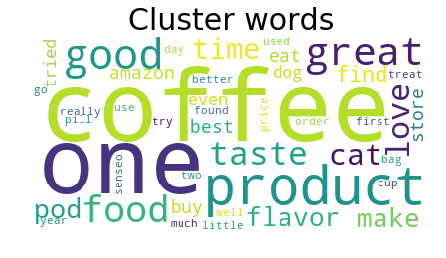

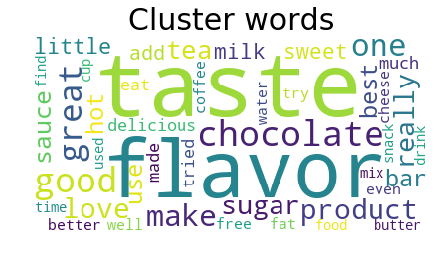

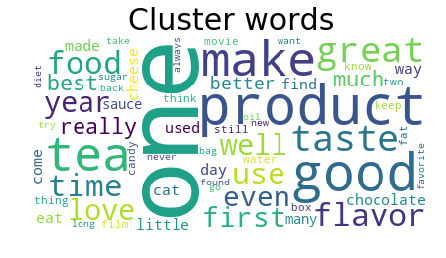

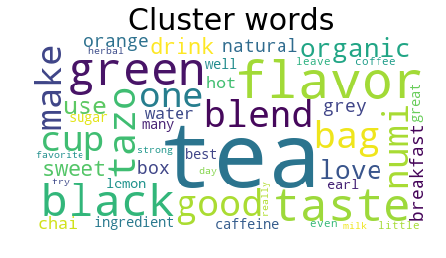

In [107]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust2:
    cloud(cl)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

In [108]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [109]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 123.69it/s]


In [110]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg_tf1 = AgglomerativeClustering(n_clusters=2).fit( tfidf_sent_vectors)

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg_tf2 = AgglomerativeClustering(n_clusters=3).fit( tfidf_sent_vectors)

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
agg_tf3 = AgglomerativeClustering(n_clusters=4).fit( tfidf_sent_vectors)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

In [113]:
clust = [ [] for i in range(2) ]
for i in range(agg_tf1.labels_.shape[0]):
    clust[agg_tf1.labels_[i]].append(X_train.values[i])

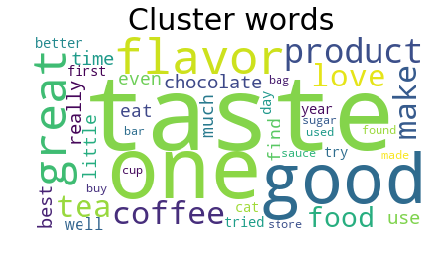

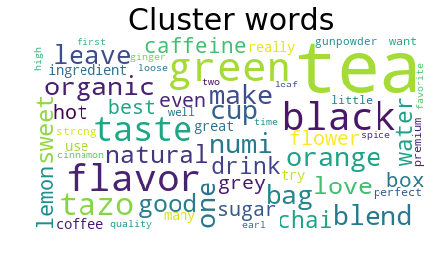

In [114]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust:
    cloud(cl)

In [122]:
clust1 = [ [] for i in range(3) ]
for i in range(agg_tf2.labels_.shape[0]):
    clust1[agg_tf2.labels_[i]].append(X_train.values[i])

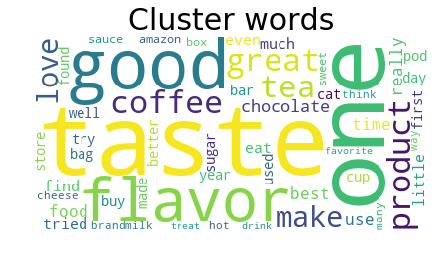

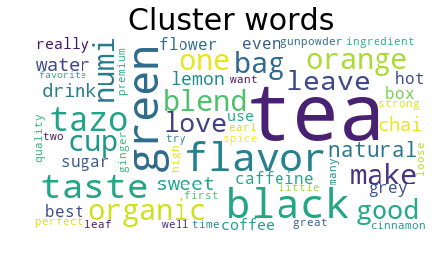

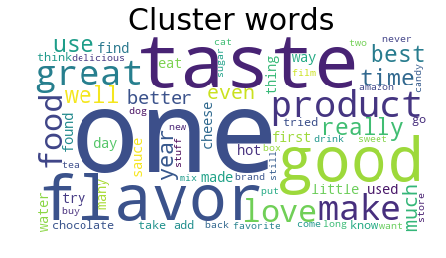

In [123]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust1:
    cloud(cl)

In [120]:
clust2 = [ [] for i in range(4) ]
for i in range(agg_tf3.labels_.shape[0]):
    clust2[agg_tf3.labels_[i]].append(X_train.values[i])

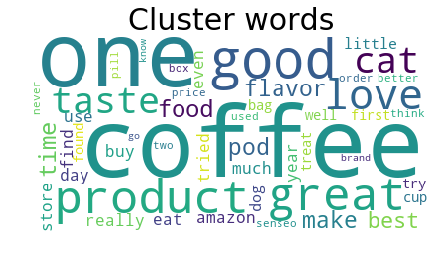

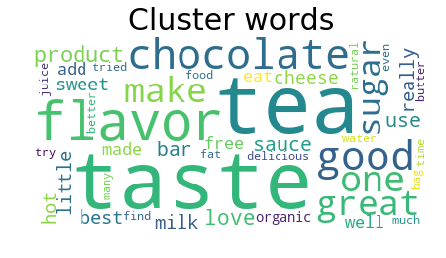

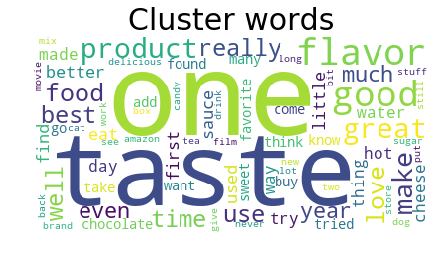

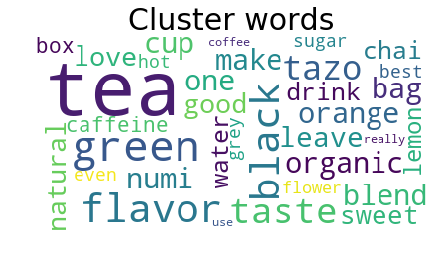

In [121]:
from wordcloud import WordCloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
def cloud(cluster):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words",size= 30,)
    plt.show() 
for cl in clust2:
    cloud(cl)

## [5.3] DBSCAN Clustering

In [124]:
# Train your own Word2Vec model using your own text corpus
i=0
sentance_train=[]
for sentance in X_train:
    sentance_train.append(sentance.split())

In [125]:
# to train the W2V model on the provided list of sentences
w2v_model=Word2Vec(sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5000
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition']


In [126]:
# we will convert the test data into W2V
# average Word2Vec
# compute average word2vec for each review.
vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    vectors_train.append(sent_vec)
print(len(vectors_train))
print(len(vectors_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 780.15it/s]


5000
50


### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [134]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(vectors_train)
data

array([[-1.59594549, -1.06275282, -0.33675116, ..., -1.71261178,
        -1.53656315,  0.20723702],
       [-2.54272459, -1.97942782, -0.72208942, ..., -2.56075481,
        -2.51625703,  0.71305309],
       [-1.54965594, -1.27316555, -0.42730573, ..., -1.59918706,
        -1.53443299,  0.37422527],
       ...,
       [ 0.62439166,  0.57151211,  1.04221614, ...,  0.66596653,
         0.04536828,  0.55232566],
       [-1.05211085, -1.04046079, -0.53820262, ...,  0.13468939,
        -0.34146755,  0.42184553],
       [-1.41956143, -0.94544323, -0.04818008, ..., -1.29687159,
        -1.08635529,  0.2450635 ]])

In [154]:
# Applying the Elbow Method to find the correct value of Epsilon

#the hyper parameter to be tuned in DBSCAN are Min points, epsilon
#consider min point to be 2*dimensionality (as per video).
# calculate the distance of points to the min_data th nearest neighbor of Xi.
# Sort the distance in increasing order. 
#the plot the point index vs distance.take the point at the deflection as epssilon

def distance(dat,min_point):

    dist =[]
    for i in data:
        point_dist = np.linalg.norm((data - i),axis=1)
    #point_dist
        point_dist = np.sort(point_dist)
    #point_dist
        dist.append(point_dist[min_point])
    dist=np.sort(dist)
    plt.plot(dist)
    plt.xlabel("Point Index")
    plt.ylabel("distance")
    plt.title("Point Index Vs Distances to find Epsilon")

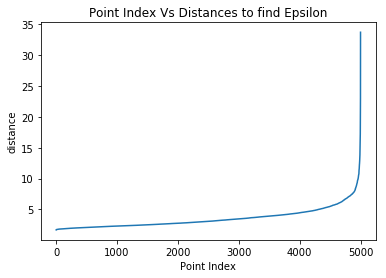

In [155]:
distance(dat=data, min_point=2*data.shape[1])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [169]:
def cloud(cluster,i):
    wordcloud = WordCloud(collocations=False, background_color ='white', 
                    min_font_size = 10).generate(str(list(cluster)))
    plt.figure(figsize = (6,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Cluster words"+str(i),size= 30,)
    plt.show() 

Epsilon Value =  7


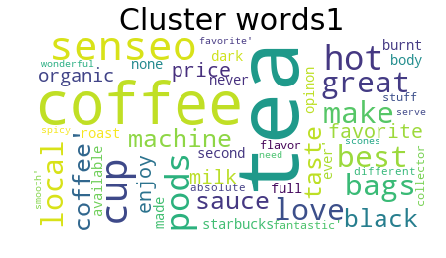

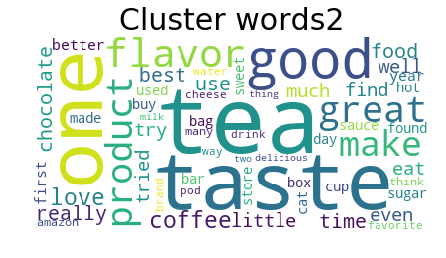

Epsilon Value =  8


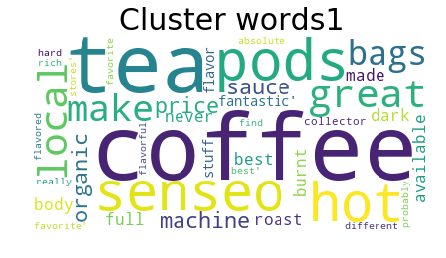

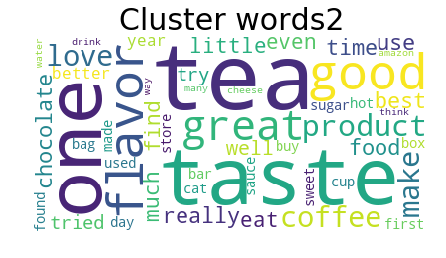

Epsilon Value =  9


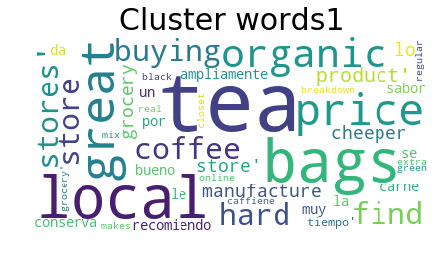

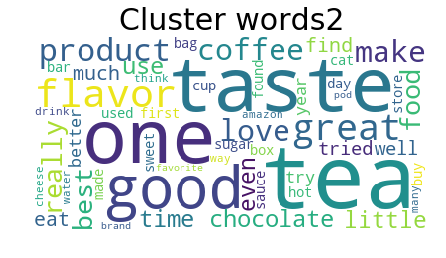

Epsilon Value =  10


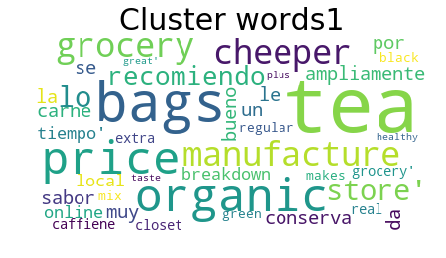

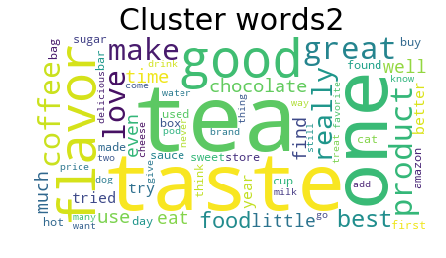

In [174]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
ep= [7,8,9,10]

for epsi in ep:
    print("Epsilon Value = ",epsi)
    dbscan = DBSCAN(eps=epsi, min_samples=2*data.shape[1]).fit(data)
    label = dbscan.labels_ +1
    clust = [ [] for i in range(len(set(label))) ]
    for i in range(label.shape[0]):
        clust[label[i]].append(X_train.values[i])
    i=1
    for cl in clust:
        cloud(cl,i)
        i+=1


1. from the elbow curve we found the best epsilon around 8-9.
2. with Ep = 7, the cluster is about tea, taste, coffee and its flavour related.
3. With Ep =8, the cluster is about tea, taste, great,love.
4. With Ep= 9, the cluster is about taste, tea and related words
5. With Ep=10, the cluster is related to good, tea, taste 

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

In [175]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [176]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.04it/s]


In [177]:
data_tf = scaler.fit_transform(tfidf_sent_vectors)

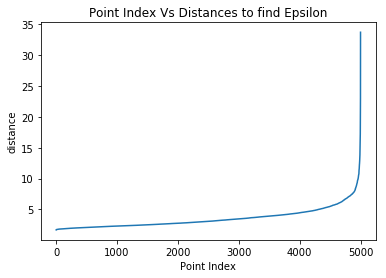

In [178]:
distance(dat=data_tf, min_point=2*data_tf.shape[1])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Epsilon Value =  7


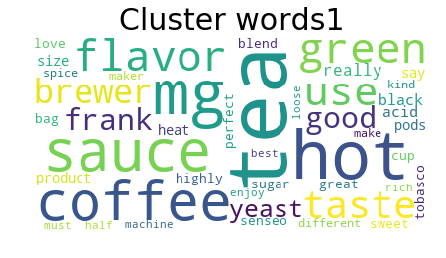

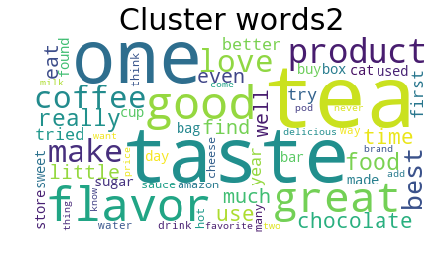

Epsilon Value =  8


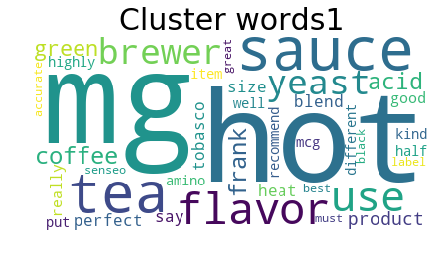

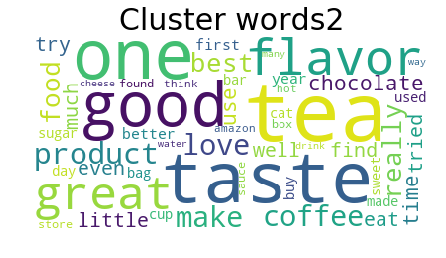

Epsilon Value =  8.5


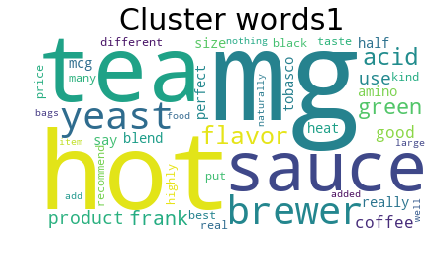

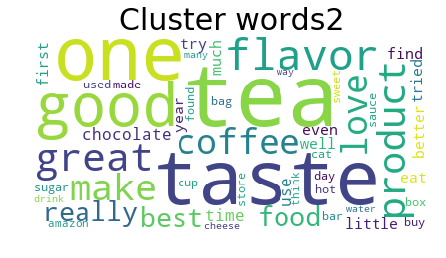

Epsilon Value =  9


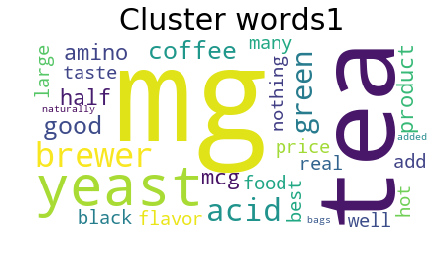

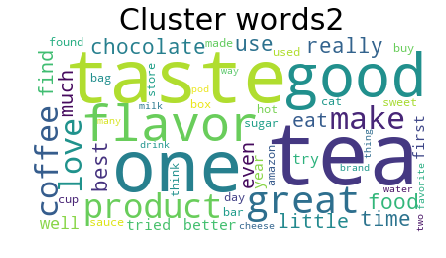

Epsilon Value =  10


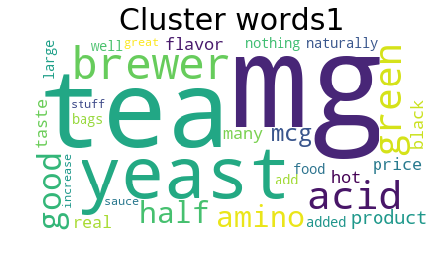

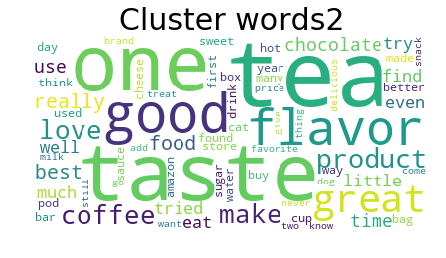

In [179]:
# we can see the epsilon could be around 8

#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
ep= [7,8,8.5,9,10]

for epsi in ep:
    print("Epsilon Value = ",epsi)
    dbscan = DBSCAN(eps=epsi, min_samples=2*data_tf.shape[1]).fit(data_tf)
    label = dbscan.labels_ +1
    clust = [ [] for i in range(len(set(label))) ]
    for i in range(label.shape[0]):
        clust[label[i]].append(X_train.values[i])
    i=1
    for cl in clust:
        cloud(cl,i)
        i+=1


# Observation


# K MEANS:

## BOW:
Optimised clusters : 6
#### cluster 1: Words like tea, flavour, cup and words related to tea and its flavour are grouped together.
#### cluster 2: Words like product, taste, amazon and words related to amazon product and its services
#### clsuter 3: Words like sweet, cereal,sugar, chocolate and words related to sweet and the products made using sugar
#### cluster 4: Words like snack, flour, store, flavour, great and words related to snacks and its quality are grouped togather.
#### cluster 5: words like coffee, drink, bean and words related to coffee and the raw ingredients used to make coffee are grouped together.
#### Cluster 6: Words like amazon, product, better,love and words related to services of amazon are grouped together.

## TFIDF:
Optimised Clusters: 7
#### Cluster 1: Words flour, bread, gluten free, cookies and words related to products made out of flour are gropued together.
#### Cluster 2: words like amazon, taste, store, and words related to amazon store are grouped together.
#### CLuster 3: Words like tea,cup,bag, and words related to tea and things used to hold tea are grouped together.
#### Cluster 4: Words like coffee, roast, blend and words related to process of coffee making are gropued together.
#### Cluster 5: Words like sugar, chocolate, dark, bar, cookie, and words relatd to sugar and product made using sugar are grouped together.
#### Cluster 6: Words like dog, cat, chicken, food and words grouped on food which animals fed.
#### Cluster 7: Words like price, store, amazon, shipping and words related to amazon services are grouped together.

## AVG W2V:
Optimised Clusters 5:
#### Cluster 1: Words like buy,store, amazon, love and words related to amazon services are grouped together.
#### Cluster 2: Words like rice, flavour,rice,chicken,and words related to groceries and its quality are grouped together.
#### Cluster 3: Words like chocolate, cookie, sugar, fruit, chip and words related to snacks and the reviews of those are grouped together.
#### CLuster 4: Words like dog,cat,eat,food,and words related to animals and the products it eat are grouped together.
#### Cluster 5: Words like coffee, tea, taste, black, blend and words related to coffee and the process of making are grouped together.

## TFIDF W2V
Optimised Clusters: 5
#### Cluster 1: Words like amazon, taste, store, and words related to amazon store are grouped together.
#### Cluster 2: Words like sugar, chocolate, dark, bar, cookie, and words relatd to sugar and product made using sugar are grouped together.
#### Cluster 3: Words like coffee, tea, cup and words related to coffee and the process of making are grouped together.
#### Cluster 4: Words like salt, sauce, flavour,and words related to groceries and taste are grouped together.
#### Cluster 5: Words like dog,cat,eat,food,and words related to animals and the products it eat are grouped together.


# Agglomerative Clustering

## AVG W2V

Cluster 2:

#### Cluster 1: Words like amazon, taste, store, and words related to amazon store are grouped together.
#### Cluster 2: Words like tea, flavour, sugar, love and words related to tea and its taste are grouped together.

Cluster 3:
#### Cluster 1: Words like tea, flavour, sugar, love and words related to tea and its taste are grouped together.
#### Cluster 2: Words like coffee, tea, cup and words related to coffee and the process of making are grouped together.
#### Cluster 3: product, good, store,amazon and words related to amazon product are gropued together

Cluster 4:
#### Cluster 1: Words like coffee, roast, blend and words related to process of coffee making are gropued together.
#### Cluster 2: Words like sugar, milk, chocolate, sweet and words related to sugar and its use in products are grouped together.
#### Cluster 3: Words like product, good, store,amazon and words related to amazon product are gropued together
#### Cluster 4: Words like caffeine, tea, lend, cup and words related to coffee and tea are grouped together.

## TFIDF W2V

Cluster 2:
#### Cluster 1: Words like product, best, taste, flavour and words that are related to positive reviews are grouped together
#### Cluster 2: Words like chai, tea, cup and words related to tea and its taste are grouped together.

Cluster 3:
#### Cluster 1: Words like tea, coffee, milk, sugar, taste and words related to coffee and ingredients used to make it are grouped together.
#### Cluster 2: Words like bag,taste,tea,cinnamon,green and words related to types of tea are grouped together.
#### Cluster 3: Words like taste, good, product, favourite and words related to positive reviews of amazon products are grouped together.

Cluster 4:
#### Cluster 1: Words like tea, cup and words related to tea and its taste are grouped together.
#### Cluster 2: Words like tea, taste flavour and words related to tea are grouped together.
#### Cluster 3: Words like taste, product,sauce, blend, cup coffee and words related to products that are majorly occuring in reviews are grouped together.
#### Cluster 4: Words like tea, black, taste, blend,cup coffee and words related to drink are grouped together.


# DBSCAN

## Avg W2V
### By varying the epsilon, we see that the similar group clustering seems to be increasing.
#### For epsilon 8, words like tea, flavour, taste, good and words related to tea and its flavour are grouped together.

## TFIDF- W2V

### By varying the epsilon, we see that the similar group clustering seems to be increasing.
#### For epsilon 9, words like tea, taste, good, time and words related to customer experience on use of tea products are grouped together

# [6] Conclusions

In [4]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

In [193]:
from prettytable import PrettyTable
    
tab = PrettyTable()

In [194]:
tab.field_names = ["Cluster Type","Vectorizer", "No. of. Cluster"]



tab.add_row(["K Means","BOW",6 ])
tab.add_row(["K Means","TFIDF",7])
tab.add_row(["K Means","AVG W2V",5])
tab.add_row(["K Means","TFIDFW2V",5])
tab.add_row(["Agglomerative","AVG W2V","2"])
tab.add_row(["Agglomerative","AVG W2V","3"])
tab.add_row(["Agglomerative","AVG W2V","4"])
tab.add_row(["Agglomerative","TFIDFW2V","2"])
tab.add_row(["Agglomerative","TFIDFW2V","3"])
tab.add_row(["Agglomerative","TFIDFW2V","4"])
tab.add_row(["DBSCAN","AVG W2V","Epsilon 9"])
tab.add_row(["DBSCAN","TFIDF W2V","Epsilon 8"])


In [195]:
print("K Means ")
print(tab)

K Means 
+---------------+------------+-----------------+
|  Cluster Type | Vectorizer | No. of. Cluster |
+---------------+------------+-----------------+
|    K Means    |    BOW     |        6        |
|    K Means    |   TFIDF    |        7        |
|    K Means    |  AVG W2V   |        5        |
|    K Means    |  TFIDFW2V  |        5        |
| Agglomerative |  AVG W2V   |        2        |
| Agglomerative |  AVG W2V   |        3        |
| Agglomerative |  AVG W2V   |        4        |
| Agglomerative |  TFIDFW2V  |        2        |
| Agglomerative |  TFIDFW2V  |        3        |
| Agglomerative |  TFIDFW2V  |        4        |
|     DBSCAN    |  AVG W2V   |    Epsilon 9    |
|     DBSCAN    | TFIDF W2V  |    Epsilon 8    |
+---------------+------------+-----------------+
